<a href="https://colab.research.google.com/github/Monalika-P/Vision-based-Human-Activity-Recognitio/blob/main/Vision_based_Human_Activity_Recognition_(5_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9MB 8.6MB/s 


In [2]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import joblib


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2039808/45929032 bytes (4.4%)5128192/45929032 bytes (11.2%)8036352/45929032 bytes (17.5%)11370496/45929032 bytes (24.8%)14794752/45929032 bytes (32.2%)18137088/45929032 bytes (39.5%)21569536/45929032 bytes (47.0%)24879104/45929032 bytes (54.2%)28213248/45929032 bytes (61.4%)31449088/45929032 bytes (68.5%)34775040/45929032 bytes (75.7%)38068224/45929032 bytes (82.9%)

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-06-25 05:22:47--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  37.7MB/s    in 51s     

2021-06-25 05:23:39 (60.5 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [6]:
image_height, image_width = 64, 64
max_images_per_class = 10000
dataset_directory = "UCF50"
classes_list = ['JumpingJack','HulaHoop','YoYo','TrampolineJumping','Mixing','PizzaTossing','SalsaSpin']
model_output_size = len(classes_list)

In [7]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    # Iterating through Video Frames
    while True:
    # Reading a frame from the video file
        success, frame = video_reader.read()
        # If Video frame was not successfully read then break the loop

        if not success:
            break

        # Resize the Frame to fixed Dimensions

        resized_frame = cv2.resize(frame, (image_height, image_width))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1

        normalized_frame = resized_frame / 255
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Closing the VideoCapture object and releasing all resources.

    video_reader.release()
    # returning the frames list

    return frames_list


In [ ]:
def create_dataset():
    # Declaring Empty Lists to store the features and labels values.
    temp_features = []
    features = []
    labels = []
    # Iterating through all the classes mentioned in the classes list

    for class_index, class_name in enumerate(classes_list):

        print(f'Extracting Data of Class: {class_name}')
        # Getting the list of video files present in the specific class name directory

        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        # Iterating through all the files present in the files list

        for file_name in files_list:
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
            temp_features.extend(frames)

        features.extend(random.sample(temp_features, max_images_per_class))
        labels.extend([class_index] * max_images_per_class)

        temp_features.clear()

    features = np.asarray(features)

    labels = np.array(labels) 

 

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: JumpingJack
Extracting Data of Class: HulaHoop
Extracting Data of Class: YoYo
Extracting Data of Class: TrampolineJumping
Extracting Data of Class: Mixing
Extracting Data of Class: PizzaTossing
Extracting Data of Class: SalsaSpin


In [ ]:
joblib.dump(features,'/content/drive/MyDrive/HARModels/features_six.pickle')

['/content/drive/MyDrive/HARModels/features_six.pickle']

In [ ]:
joblib.dump(labels,'/content/drive/MyDrive/HARModels/labels_six.pickle')

['/content/drive/MyDrive/HARModels/labels_six.pickle']

In [ ]:
features = joblib.load('/content/drive/MyDrive/HARModels/features_six.pickle')

In [ ]:
labels = joblib.load('/content/drive/MyDrive/HARModels/labels_six.pickle')

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [11]:
# Let's create a function that will construct our model
def create_model():
 # We will use a Sequential model for model construction
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 64, 3)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # Printing the models summary

    model.summary()

    return model
# Calling the create_model method
model = create_model()

print("Model Created Successfully!")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 62, 62, 62, 32)    2624      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 31, 31, 31, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 31, 32)    128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 31, 32)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 29, 29, 29, 64)    55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 14, 14, 14, 64)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 14, 64)   

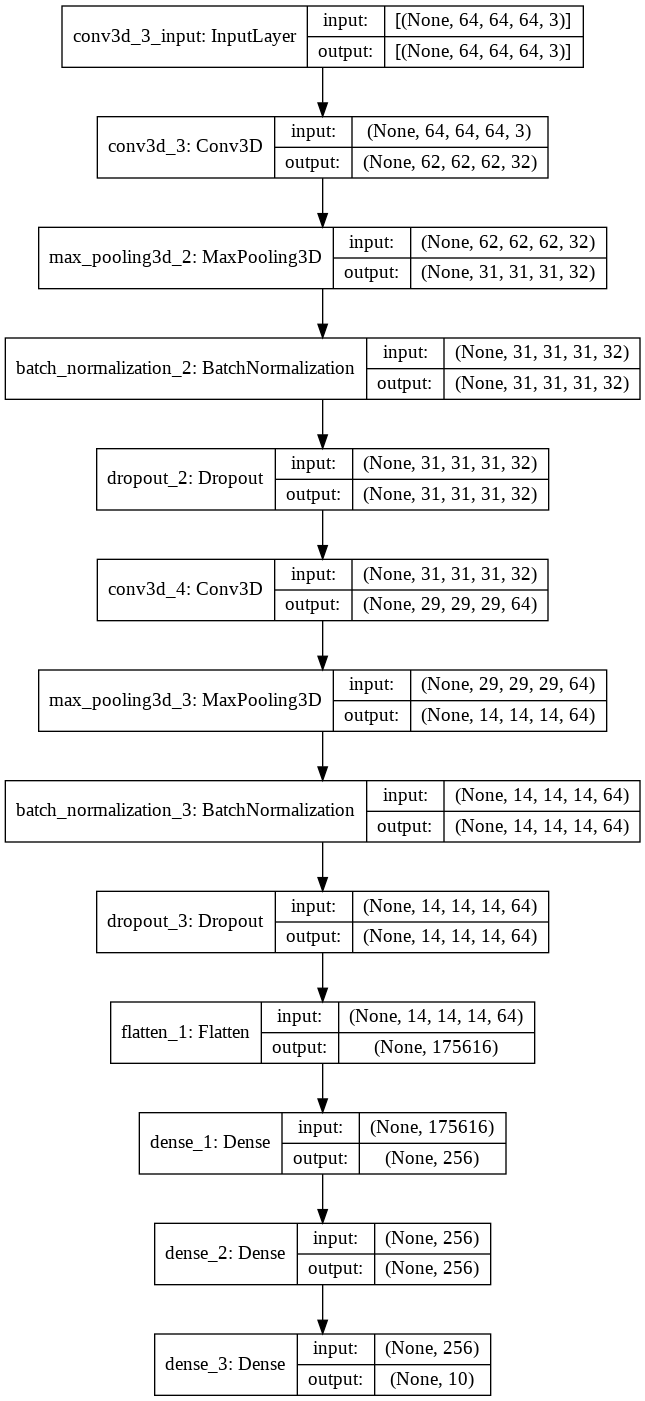

In [12]:
	plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/HARModels/har_fiveclasses.h5')

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
# Adding loss, optimizer and metrics values to the model.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HARModels/har_fiveclasses.h5', monitor = 'val_loss', verbose = 1, save_best_only = True,
                                                mode = 'min')
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 20 , batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,checkpoint])

Epoch 1/20
560/560 [==============================] - 477s 848ms/step - loss: 1.0808 - accuracy: 0.6166 - val_loss: 1.1264 - val_accuracy: 0.5520

Epoch 00001: val_loss improved from inf to 1.12638, saving model to /content/drive/MyDrive/HARModels/har_fiveclasses.h5
Epoch 2/20
560/560 [==============================] - 475s 847ms/step - loss: 0.2124 - accuracy: 0.9418 - val_loss: 0.4706 - val_accuracy: 0.8328

Epoch 00002: val_loss improved from 1.12638 to 0.47064, saving model to /content/drive/MyDrive/HARModels/har_fiveclasses.h5
Epoch 3/20
560/560 [==============================] - 473s 844ms/step - loss: 0.0790 - accuracy: 0.9800 - val_loss: 0.1201 - val_accuracy: 0.9563

Epoch 00003: val_loss improved from 0.47064 to 0.12005, saving model to /content/drive/MyDrive/HARModels/har_fiveclasses.h5
Epoch 4/20
560/560 [==============================] - 473s 844ms/step - loss: 0.0509 - accuracy: 0.9868 - val_loss: 0.1724 - val_accuracy: 0.9377

Epoch 00004: val_loss did not improve from 0

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)


175/175 [==============================] - 34s 192ms/step - loss: 0.0385 - accuracy: 0.9882


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  epochs = range(len(metric_value_1))
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  plt.title(str(plot_name))
  # Adding legend to the plot
  plt.legend()

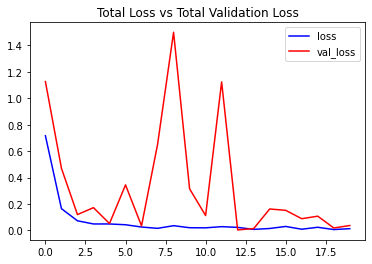

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

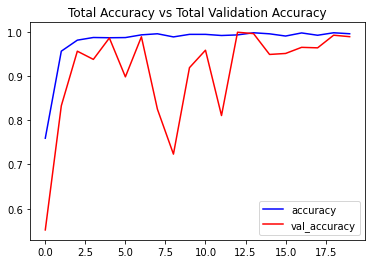

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True:

        status, frame = video_reader.read()

        if not status:

            break

        resized_frame = cv2.resize(frame, (image_height, image_width))

        normalized_frame = resized_frame / 255

        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        if len(predicted_labels_probabilities_deque) == window_size:

            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            predicted_class_name = classes_list[predicted_label]

            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
window_size = 1

output_video_file_path = 'output.mp4'

predict_on_live_video('/content/test.mp4', output_video_file_path, window_size)

#VideoFileClip(output_video_file_path).ipython_display(width = 700)